In [1]:
suppressPackageStartupMessages({
    library(monocle)
    
    library(RColorBrewer)
    library(dplyr)
    library(ggplot2)
    library(reshape2)
    library(scales)
})

Warning message:
“replacing previous import by ‘splines::splineDesign’ when loading ‘VGAM’”Warning message:
“replacing previous import by ‘grid::arrow’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘grid::unit’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘igraph::clusters’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘ggplot2::Position’ when loading ‘monocle’”

This analysis was made using Monocle version 2.3.5. The source code for Monocle 2.3.5 is available as a supplementary file to Cao et al. 2017 on the Science website. We are working on updating the analysis to the latest version of Monocle.

In [2]:
sessionInfo()

R version 3.2.1 (2015-06-18)
Platform: x86_64-unknown-linux-gnu (64-bit)
Running under: CentOS release 6.8 (Final)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] splines   stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] scales_0.4.1        reshape2_1.4.2      dplyr_0.7.1        
 [4] RColorBrewer_1.1-2  monocle_2.3.5       DDRTree_0.1.5      
 [7] irlba_2.2.1         VGAM_1.0-3          ggplot2_2.2.1      
[10] Biobase_2.30.0      BiocGenerics_0.16.1 Matrix_1.2-7.1     

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.11           bindr_0.1              plyr_1

In [ ]:
load("RData/L2.gene.reports.RData")

In [2]:
load("RData/L2.data.summaries.no-cruft.RData")

In [ ]:
pData(cds.experiment.1)$cell.type = with(pData(cds.experiment.1), ifelse(
    !is.na(cell.type) & cell.type == "Pharyngeal.neurons", "Pharyngeal neurons", cell.type))

In [ ]:
fData(cds.experiment.2)$gene_id = fData(cds.experiment.2)$gene

In [ ]:
cell.type.tables = list()

for (ct in cell.types) {
    message(ct)
    
    if (ct == "Intestine")
        tmp.cds = cds.experiment.2[, with(pData(cds.experiment.2), !is.na(cell.type) & cell.type == ct)]
    else
        tmp.cds = cds.experiment.1[, with(pData(cds.experiment.1), !is.na(cell.type) & cell.type == ct)]
        
    tmp.cds = estimateSizeFactors(tmp.cds)
    tmp.cds = estimateDispersions(tmp.cds)
    tmp.cds = detectGenes(tmp.cds, 0.1)
        
    cell.type.tables[[ct]] = data.frame(
            gene_id = fData(tmp.cds)$gene_id,
            symbol = fData(tmp.cds)$symbol,
            n = ncol(tmp.cds),
            mu_hat = cell.type.norm.means[, ct]) %>%
        inner_join(
            dispersionTable(tmp.cds) %>%
                select(gene_id, alpha_hat = dispersion_empirical), by = "gene_id") %>%
        mutate(
            var_hat = mu_hat + mu_hat ^2 * alpha_hat,
            ci.95p.lo = qnorm(0.05, mean = mu_hat, sd = sqrt(var_hat / n)),
            ci.95p.hi = qnorm(0.95, mean = mu_hat, sd = sqrt(var_hat / n)))
        
    cell.type.tables[[ct]]$tpm = with(cell.type.tables[[ct]],
        (mu_hat / sum(mu_hat)) * 1000000)
        
    cell.type.tables[[ct]]$tpm.ci.lo = with(cell.type.tables[[ct]],
        (ci.95p.lo / mu_hat) * tpm)
        
    cell.type.tables[[ct]]$tpm.ci.hi = with(cell.type.tables[[ct]],
        (ci.95p.hi / mu_hat) * tpm)
}

rm(tmp.cds)

In [ ]:
for (ct in cell.types) {
    cell.type.tables[[ct]]$cell.type = ct
    cell.type.tables[[ct]]$tpm.ci.lo = pmax(0, cell.type.tables[[ct]]$tpm.ci.lo)
    cell.type.tables[[ct]] = cell.type.tables[[ct]] %>%
        select(gene_id, symbol, cell.type, tpm, tpm.ci.lo, tpm.ci.hi)
}

In [7]:
cell.type.tpm.ci.df = do.call(rbind, cell.type.tables)

In [3]:
#tmp.df = cell.type.tpm.ci.df %>% filter(symbol == "ztf-7")
#tmp.df = cell.type.tpm.ci.df %>% filter(symbol == "F37C12.14")
tmp.df = cell.type.tpm.ci.df %>% filter(symbol == "rnt-1")

if (length(unique(tmp.df$cell.type)) < length(cell.types)) {
    this.symbol = as.character(tmp.df$symbol[1])
    
    tmp.df = rbind(tmp.df, data.frame(
        gene_id = tmp.df$gene_id[1],
        symbol = this.symbol,
        cell.type = setdiff(cell.types, unique(tmp.df$cell.type))) %>%
        inner_join(data.frame(
            cell.type = names(cell.type.tpm[this.symbol,]),
            tpm = cell.type.tpm[this.symbol,]), by = "cell.type") %>%
        mutate(
            tpm.ci.lo = ifelse(tpm > 0, NA, 0),
            tpm.ci.hi = ifelse(tpm > 0, NA, 0)))
}

tmp.df$tissue.for.coloring = sapply(tmp.df$cell.type, function(x) {
    switch(x,
        "Body wall muscle" = "BWM/IRM",
        "Intestinal/rectal muscle" = "BWM/IRM",
        "Pharyngeal muscle" = "Pharynx",
        "Pharyngeal epithelia" = "Pharynx",
        "Pharyngeal gland" = "Pharynx",
        "Seam cells" = "Hypodermis",
        "Non-seam hypodermis" = "Hypodermis",
        "Rectum" = "Hypodermis",
        "Ciliated sensory neurons" = "Neurons",
        "Oxygen sensory neurons" = "Neurons",
        "Touch receptor neurons" = "Neurons",
        "Cholinergic neurons" = "Neurons",
        "GABAergic neurons" = "Neurons",
        "Pharyngeal neurons" = "Neurons",
        "flp-1(+) interneurons" = "Neurons",
        "Other interneurons" = "Neurons",
        "Canal associated neurons" = "Neurons",
        "Am/PH sheath cells" = "Glia",
        "Socket cells" = "Glia",
        "Excretory cells" = "Glia",
        "Intestine" = "Intestine",
        "Germline" = "Gonad",
        "Somatic gonad precursors" = "Gonad",
        "Distal tip cells" = "Gonad",
        "Vulval precursors" = "Gonad",
        "Sex myoblasts" = "Gonad",
        "Coelomocytes" = "Other")
})

tmp.df$tissue.for.coloring = ifelse(is.na(tmp.df$tpm.ci.lo),
    "Low sample size", tmp.df$tissue.for.coloring)

tmp.df$tissue.for.coloring = factor(tmp.df$tissue.for.coloring, levels = c(
    "BWM/IRM", "Pharynx", "Hypodermis", "Neurons", "Glia", "Intestine", "Gonad", "Other", "Low sample size"))

tmp.df$tpm.ci.lo = ifelse(tmp.df$tpm == 0, NA, tmp.df$tpm.ci.lo)
tmp.df$tpm.ci.hi = ifelse(tmp.df$tpm == 0, NA, tmp.df$tpm.ci.hi)

tmp.df$cell.type = factor(tmp.df$cell.type, levels = rev(c(
    "Body wall muscle",
    "Intestinal/rectal muscle",
    "Pharyngeal muscle",
    "Pharyngeal epithelia",
    "Pharyngeal gland",
    "Seam cells",
    "Non-seam hypodermis",
    "Rectum",
    "Ciliated sensory neurons",
    "Oxygen sensory neurons",
    "Touch receptor neurons",
    "Cholinergic neurons",
    "GABAergic neurons",
    "Pharyngeal neurons",
    "flp-1(+) interneurons",
    "Other interneurons",
    "Canal associated neurons",
    "Am/PH sheath cells",
    "Socket cells",
    "Excretory cells",
    "Intestine",
    "Germline",
    "Somatic gonad precursors",
    "Distal tip cells",
    "Vulval precursors",
    "Sex myoblasts",
    "Coelomocytes")))

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factors with different levels, coercing to character vector”

In [4]:
tmp.df

gene_id,symbol,cell.type,tpm,tpm.ci.lo,tpm.ci.hi,tissue.for.coloring
WBGene00004393,rnt-1,Germline,0.5718662,0.000000,1.270365,Gonad
WBGene00004393,rnt-1,Intestinal/rectal muscle,7.4385053,0.000000,17.289972,BWM/IRM
WBGene00004393,rnt-1,Seam cells,10.2858973,5.790142,14.781653,Hypodermis
WBGene00004393,rnt-1,Non-seam hypodermis,1.0745069,0.000000,3.005852,Hypodermis
WBGene00004393,rnt-1,Body wall muscle,33.7208061,29.458958,37.982655,BWM/IRM
WBGene00004393,rnt-1,Sex myoblasts,11.1801348,0.000000,24.248455,Gonad
WBGene00004393,rnt-1,Coelomocytes,0.0000000,NA,NA,Other
WBGene00004393,rnt-1,Ciliated sensory neurons,0.0000000,NA,NA,Neurons
WBGene00004393,rnt-1,Pharyngeal epithelia,3.5937935,NA,NA,Low sample size
WBGene00004393,rnt-1,Touch receptor neurons,0.0000000,NA,NA,Neurons


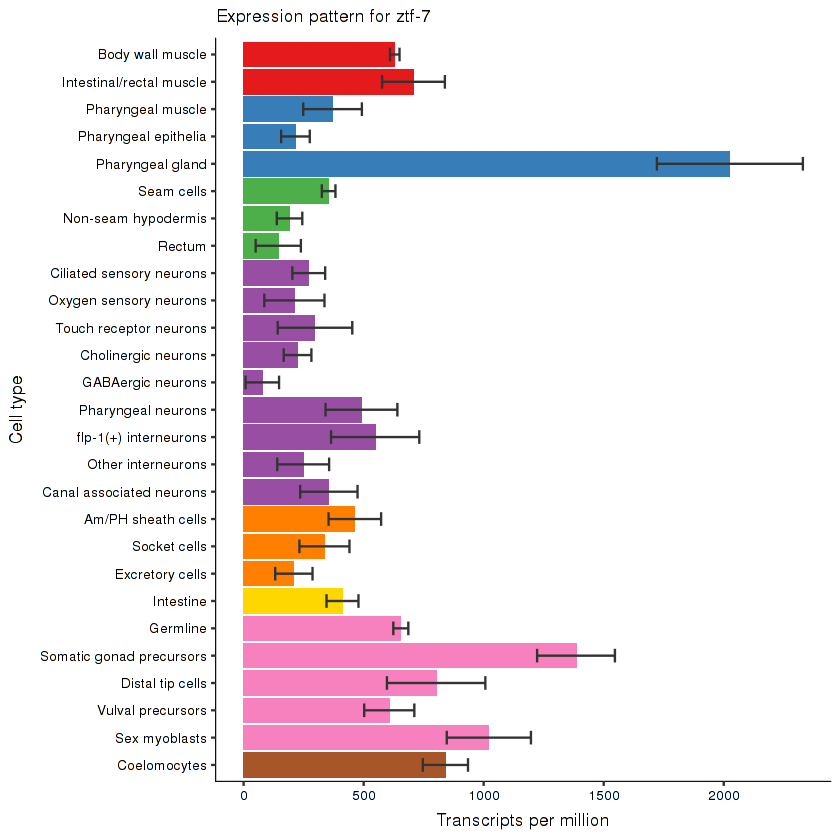

In [86]:
plot = ggplot(tmp.df, aes(x = cell.type, y = tpm, ymin = tpm.ci.lo, ymax = tpm.ci.hi)) +
    geom_bar(aes(fill = tissue.for.coloring), stat = "identity") +
    geom_errorbar(size = 0.5, width = 0.5, color = "grey20") +
    geom_point(aes(y = tpm + 0.018 * max(tpm), alpha = tissue.for.coloring == "Low sample size"),
               shape = 42, size = 6) +
    coord_flip() +
    xlab("Cell type") +
    ylab("Transcripts per million") +
    ggtitle("Expression pattern for ztf-7") +
    guides(fill = F, alpha = F) +
    scale_fill_manual(values = c(
        "#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "gold", "#F781BF", "#A65628", "#999999")) +
    scale_alpha_manual(values = c(0, 1)) +
    monocle:::monocle_theme_opts() +
    theme(
        plot.title = element_text(size = 10),
        axis.title.x = element_text(size = 10, margin = margin(8, 0, 0, 0)),
        axis.title.y = element_text(size = 10, margin = margin(0, 8, 0, 0)),
        axis.text.x = element_text(size = 8, color = "black"),
        axis.text.y = element_text(size = 8, color = "black"))

show(plot)

ggsave("plots/Fig_S14.pdf", plot = plot,
    device = cairo_pdf, units = "in", width = 4, height = 5)

In [10]:
save.image("RData/L2.gene.reports.RData")

In [11]:
save(cell.type.tpm.ci.df, file = "RData/cell.type.tpm.ci.df.RData")

In [10]:
gene.id.to.symbol = fData(cds.experiment.1)[, c("gene_id", "symbol")]
save(gene.id.to.symbol, file = "RData/gene.id.to.symbol.RData")

In [14]:
write(as.character(fData(cds.experiment.1)$gene_id), file = "RData/WBGenes")

In [71]:
?max

In [8]:
levels(tmp.df$tissue.for.coloring)

[1] "BWM/IRM"         "Pharynx"         "Hypodermis"      "Neurons"        
[5] "Glia"            "Intestine"       "Gonad"           "Other"          
[9] "Low sample size"

In [10]:
jpeg("plots/gene_report_test.jpg", width = 1100, height = 1100, type = "cairo")
ggplot(tmp.df, aes(x = cell.type, y = tpm, ymin = tpm.ci.lo, ymax = tpm.ci.hi)) +
    geom_bar(aes(fill = tissue.for.coloring), stat = "identity") +
    geom_errorbar(size = 1.0, width = 0.5, color = "grey20") +
    geom_point(aes(y = tpm + 0.02 * max(tpm), alpha = tissue.for.coloring == "Low sample size"),
               shape = 42, size = 14) +
    coord_flip() +
    xlab("Cell type") +
    ylab("Transcripts per million") +
    ggtitle("Expression pattern for ztf-7") +
    guides(fill = F, alpha = F) +
    scale_y_continuous(limits = c(0,
        max(1.02 * max(tmp.df$tpm),
            max(tmp.df$tpm.ci.hi, na.rm = T)))) +
    scale_fill_manual(values = c(
        "BWM/IRM" = "#E41A1C",
        "Pharynx" = "#377EB8",
        "Hypodermis" = "#4DAF4A",
        "Neurons" = "#984EA3",
        "Glia" = "#FF7F00",
        "Intestine" = "gold",
        "Gonad" = "#F781BF",
        "Other" = "#A65628",
        "Low sample size" = "#999999")) +
    scale_alpha_manual(values = c(0, 1)) +
    monocle:::monocle_theme_opts() +
    theme(
        plot.title = element_text(size = 25, hjust = 0.5),
        plot.margin = margin(10, 40, 10, 20),
        axis.title.x = element_text(size = 25, margin = margin(10, 0, 0, 0)),
        axis.title.y = element_text(size = 25, margin = margin(0, 8, 0, 0)),
        axis.text.x = element_text(size = 20, color = "black"),
        axis.text.y = element_text(size = 20, color = "black"))
dev.off()

Warning message:
“Removed 21 rows containing missing values (geom_errorbar).”

PNG 
  2

In [11]:
jpeg("plots/gene_report_thumb_test.jpg", width = 250, height = 250, type = "cairo")
ggplot(tmp.df, aes(x = cell.type, y = tpm, ymin = tpm.ci.lo, ymax = tpm.ci.hi)) +
    geom_bar(aes(fill = tissue.for.coloring), stat = "identity") +
    geom_errorbar(size = 0.8, width = 0.5, color = "grey20") +
    geom_point(aes(y = tpm + 0.018 * max(tpm), alpha = tissue.for.coloring == "Low sample size"),
               shape = 42, size = 4) +
    coord_flip() +
    xlab("Cell type") +
    ylab("Transcripts per million") +
    guides(fill = F, alpha = F) +
    scale_y_continuous(limits = c(0,
        max(1.02 * max(tmp.df$tpm),
            max(tmp.df$tpm.ci.hi, na.rm = T)))) +
    scale_fill_manual(values = c(
        "BWM/IRM" = "#E41A1C",
        "Pharynx" = "#377EB8",
        "Hypodermis" = "#4DAF4A",
        "Neurons" = "#984EA3",
        "Glia" = "#FF7F00",
        "Intestine" = "gold",
        "Gonad" = "#F781BF",
        "Other" = "#A65628",
        "Low sample size" = "#999999")) +
    scale_alpha_manual(values = c(0, 1)) +
    theme_bw() +
    theme(
        plot.margin = margin(5, 20, 5, 10),
        axis.line = element_blank(),
        panel.border = element_blank(),
        panel.grid = element_blank(),
        axis.title.x = element_text(),
        axis.title.y = element_text(),
        axis.text.x = element_text(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank())
dev.off()

Warning message:
“Removed 21 rows containing missing values (geom_errorbar).”

PNG 
  2

In [89]:
save(cell.type.tpm, file = "RData/cell.type.tpm.RData")